In [5]:
!pip install notebook_utils

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.inference_engine import IECore

In [13]:
import requests
url_xml = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.xml"
url_bin =  "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.bin"

xml = requests.get(url_xml)
bin = requests.get(url_bin)
with open("horizontal-text-detection-0001.xml", "wb") as f:
    f.write(xml.content)

with open("horizontal-text-detection-0001.bin", "wb") as f:
    f.write(bin.content)

In [15]:
ie = IECore()

net = ie.read_network(
    model = "models/horizontal-text-detection-0001.xml",
    weights = "models/horizontal-text-detection-0001.bin"
)
exec_net = ie.load_network(net, "CPU")

output_layer_ir = next(iter(exec_net.outputs))
input_layer_ir = next(iter(exec_net.input_info))

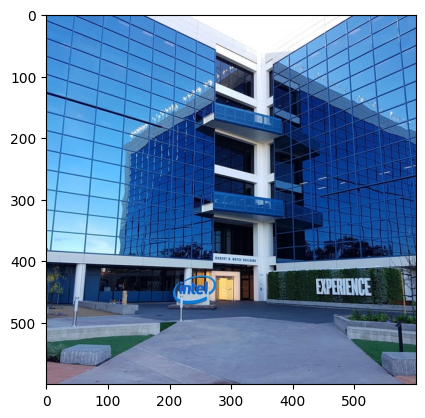

In [17]:
image = cv2.imread("data/sample.jpg")

batch_size, num_channels, height, width = net.input_info[input_layer_ir].tensor_desc.dims

resized_image = cv2.resize(image, (width, height))

input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [18]:
result = exec_net.infer(inputs={input_layer_ir:input_image})

boxes = result["boxes"]

boxes = boxes[~np.all(boxes==0, axis=1)]

In [19]:
# For each detection, the description has the format: [x_min, y_min, x_max, y_max, conf]
# Image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib we use cvtColor funtion
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert base image from bgr to rgb format
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image,
            # we position upper box bar little bit lower to make it visible on image
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw box based on position, parameters in rectangle function are: image, start_point, end_point, color, thickness
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to image based on position and confidence
            # Parameters in text function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

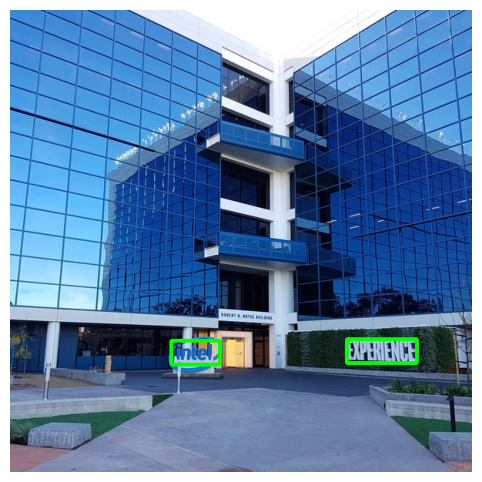

In [25]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));